# 🤖 Fine-Tuning Qwen2.5-3B for Function Calling with QLoRA

**Author (Yazar):** Mustafa Haybat Gözgöz  
**LinkedIn:** [mustafa-haybat-gozgoz35](https://www.linkedin.com/in/mustafa-haybat-gozgoz35)  
**GitHub:** *(will be added after upload)*  
**Date:** February 2026  

---

## Project Summary (Proje Özeti)

Fine-tuning Qwen2.5-3B-Instruct on glaive-function-calling-v2 dataset
using QLoRA to improve tool/function calling accuracy.

| | Base Model | Fine-Tuned (120 steps) |
|--|--|--|
| Overall Accuracy | 80.0% | 93.0% |
| Tool-call Accuracy | 29.6% | 85.2% |
| Plain-text Accuracy | 98.6% | 95.9% |

**Key Result:** Tool-call accuracy improved by +55.6% 🚀

---

## Requirements (Gereksinimler)
- Google Colab Free Tier (T4 GPU)
- Unsloth + TRL + Transformers
- Dataset: glaiveai/glaive-function-calling-v2

In [2]:
import torch
torch.cuda.is_available()

True

# 🤖 LLM Fine-Tuning: Function Calling (Fonksiyon Çağırma)

## What we do (Ne yapıyoruz):
Fine-tune Qwen2.5-3B to correctly call tools in JSON format.
(Qwen2.5-3B'yi JSON formatında araç çağırması için eğitiyoruz.)

## Key concepts (Temel kavramlar):
- QLoRA: Train only ~1% of parameters (Sadece ~%1 parametre eğit)
- Function calling: Output JSON when tool needed (Araç gerekince JSON çıktısı ver)
- Dataset: glaive-function-calling-v2 (~20k examples)

## Goal (Hedef):
Tool-call accuracy: ~30% → 60%+ after fine-tuning
(Araç çağrısı doğruluğu: ~30% → fine-tuning sonrası 60%+)

In [3]:
# ============================================================
# INSTALL LIBRARIES (KÜTÜPHANELERİ YÜKLE)
# ============================================================

import subprocess, sys

print("📦 Installing Unsloth... (Unsloth yükleniyor...)")
subprocess.run([sys.executable, "-m", "pip", "install",
    "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git",
    "--quiet"], check=True)

subprocess.run([sys.executable, "-m", "pip", "install",
    "--no-deps", "trl", "peft", "accelerate", "bitsandbytes",
    "--quiet"], check=True)

print("✅ Done! (Tamamlandı!)")

📦 Installing Unsloth... (Unsloth yükleniyor...)
✅ Done! (Tamamlandı!)


## GPU Check (GPU Kontrolü)
Verifying T4 GPU is active before loading model.
(Model yüklemeden önce T4 GPU'nun aktif olduğunu doğruluyoruz.)

In [4]:
# GPU CHECK (GPU KONTROLÜ)
# ============================================================

import torch

print("=" * 50)
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✅ VRAM: {torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB")
else:
    print("❌ No GPU! Go to Runtime > Change runtime type > T4 GPU")

print(f"   BF16 supported (BF16 destekleniyor): {torch.cuda.is_bf16_supported()}")
print("=" * 50)

✅ GPU: Tesla T4
✅ VRAM: 15.6 GB
   BF16 supported (BF16 destekleniyor): True


## Model Loading (Model Yükleme)

Loading Qwen2.5-3B with 4-bit quantization + LoRA adapter.
(Qwen2.5-3B'yi 4-bit quantization + LoRA adaptörüyle yüklüyoruz.)

- 4-bit quantization → 8x less memory (8x daha az bellek)
- LoRA r=16 → only ~1% of parameters trained (~%1 parametre eğitilir)
- MAX_SEQ_LENGTH=1024 → fits in T4 VRAM (T4 VRAM'e sığar)

In [5]:
# LOAD MODEL + LORA (MODEL + LORA YÜKLE)
# ============================================================

from unsloth import FastLanguageModel
import torch

MAX_SEQ_LENGTH = 1024   # Fits in T4 VRAM (T4 VRAM'e sığar)

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Qwen2.5-3B-Instruct-bnb-4bit",
    max_seq_length=MAX_SEQ_LENGTH,
    dtype=None,
    load_in_4bit=True,
)

model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=["q_proj","k_proj","v_proj","o_proj",
                    "gate_proj","up_proj","down_proj"],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=42,
)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"✅ Model loaded! (Model yüklendi!)")
print(f"   Trainable params (Eğitilebilir): {trainable:,} / {total:,}")
print(f"   Percentage (Yüzde): %{100*trainable/total:.2f}")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2026.2.1: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.563 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.05G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Unsloth 2026.2.1 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


✅ Model loaded! (Model yüklendi!)
   Trainable params (Eğitilebilir): 29,933,568 / 1,728,606,208
   Percentage (Yüzde): %1.73


## Dataset Loading (Veri Seti Yükleme)

Loading glaive-function-calling-v2.
(glaive-function-calling-v2 yükleniyor.)

- Shuffle with seed=42 for reproducibility (Tekrarlanabilirlik için karıştır)
- Train: rows 0–2499 (2500 examples / örnek)
- Eval : rows 2500–2699 (200 examples / örnek)

In [6]:
# LOAD + SPLIT DATASET (VERİ SETİNİ YÜKLE + BÖL)
# ============================================================

from datasets import load_dataset

raw_dataset = load_dataset("glaiveai/glaive-function-calling-v2", split="train")
shuffled    = raw_dataset.shuffle(seed=42)

train_ds_raw = shuffled.select(range(2500))
eval_ds_raw  = shuffled.select(range(2500, 2700))

print(f"✅ Dataset loaded (Veri seti yüklendi):")
print(f"   Train (Eğitim): {len(train_ds_raw):,}")
print(f"   Eval  (Test)  : {len(eval_ds_raw):,}")

README.md:   0%|          | 0.00/106 [00:00<?, ?B/s]

glaive-function-calling-v2.json:   0%|          | 0.00/271M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/112960 [00:00<?, ? examples/s]

✅ Dataset loaded (Veri seti yüklendi):
   Train (Eğitim): 2,500
   Eval  (Test)  : 200


## Chat Template Conversion (Chat Template Dönüşümü)

The dataset uses <functioncall> tags for tool calls.
(Veri seti araç çağrıları için <functioncall> tag'leri kullanıyor.)

  ASSISTANT: <functioncall> {"name": "get_weather", "arguments": '{"city": "NY"}'}

We convert this to Qwen2.5 format:
(Bunu Qwen2.5 formatına dönüştürüyoruz:)

  <|im_start|>assistant
  {"name": "get_weather", "arguments": {"city": "NY"}}
  <|im_end|>

In [7]:
# CHAT TEMPLATE CONVERSION (CHAT TEMPLATE DÖNÜŞÜMÜ)
# Handles <functioncall> tags correctly
# (<functioncall> tag'lerini doğru şekilde işler)
# ============================================================

import re, json

def convert_to_chat_format(example):
    messages = []

    system_prompt = re.sub(r'^SYSTEM:\s*', '',
                           example.get('system','').strip())
    if system_prompt:
        messages.append({"role": "system", "content": system_prompt})

    chat_text = example.get('chat', '')
    turns = re.split(r'(USER:|ASSISTANT:|FUNCTION RESPONSE:)', chat_text)
    turns = [t.strip() for t in turns if t.strip()]

    i = 0
    while i < len(turns):
        marker  = turns[i]
        content = turns[i+1].strip() if i+1 < len(turns) else ""
        content = content.replace('<|endoftext|>', '').strip()

        if marker == 'USER:':
            if content:
                messages.append({"role": "user", "content": content})
            i += 2

        elif marker == 'ASSISTANT:':
            if content:
                fc = re.search(r'<functioncall>\s*(\{.*?\})\s*$',
                               content, re.DOTALL)
                if fc:
                    try:
                        parsed = json.loads(fc.group(1))
                        if isinstance(parsed.get('arguments'), str):
                            try:
                                parsed['arguments'] = json.loads(parsed['arguments'])
                            except:
                                pass
                        clean = json.dumps(parsed)
                    except:
                        clean = fc.group(1)
                    messages.append({"role": "assistant", "content": clean})
                else:
                    messages.append({"role": "assistant", "content": content})
            i += 2

        elif marker == 'FUNCTION RESPONSE:':
            i += 2
        else:
            i += 1

    if len(messages) < 2:
        return {"text": ""}

    text = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=False)
    return {"text": text}


# Apply to both sets (Her iki sete uygula)
train_ds = train_ds_raw.map(convert_to_chat_format, num_proc=2)
train_ds = train_ds.filter(lambda x: len(x["text"]) > 50)

eval_ds = eval_ds_raw.map(convert_to_chat_format, num_proc=2)
eval_ds = eval_ds.filter(lambda x: len(x["text"]) > 50)

print(f"✅ Conversion done (Dönüşüm tamamlandı):")
print(f"   Train: {len(train_ds):,} | Eval: {len(eval_ds):,}")

Map (num_proc=2):   0%|          | 0/2500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

✅ Conversion done (Dönüşüm tamamlandı):
   Train: 2,500 | Eval: 200


## Evaluation Functions (Değerlendirme Fonksiyonları)

Two helper functions (İki yardımcı fonksiyon):
1. extract_function_call → extracts function name from text
   (metinden fonksiyon adını çıkarır)
2. strict_eval_accuracy → measures % correct on FIRST assistant turn
   (İLK asistan turunda % doğruluğu ölçer)

Why first turn? (Neden ilk tur?)
The first assistant turn is where the model decides:
call a tool (JSON) or respond directly (plain text).
(İlk asistan turu modelin kararı verdiği yerdir:
araç çağır (JSON) veya direkt cevap ver (düz metin).)

In [8]:
# EVALUATION FUNCTIONS (DEĞERLENDİRME FONKSİYONLARI)
# ============================================================

import json, re, torch
from unsloth import FastLanguageModel


def extract_function_call(text):
    """Extract function name from assistant response.
    (Asistan cevabından fonksiyon adını çıkar.)"""
    clean = text.split("<|im_end|>")[0].strip()
    try:
        parsed = json.loads(clean)
        if "name" in parsed:
            return parsed
    except:
        pass
    try:
        fixed = re.sub(
            r'"arguments"\s*:\s*\'({.*?})\'',
            lambda m: '"arguments": ' + m.group(1),
            clean, flags=re.DOTALL)
        parsed = json.loads(fixed)
        if "name" in parsed:
            return parsed
    except:
        pass
    name_match = re.search(r'"name"\s*:\s*"([^"]+)"', clean)
    if name_match:
        return {"name": name_match.group(1), "arguments": {}}
    return None


def has_tool_call_in_text(text):
    """Check if formatted text contains a tool call.
    (Formatlanmış metnin araç çağrısı içerip içermediğini kontrol et.)"""
    try:
        parts = text.split("<|im_start|>assistant")
        for part in parts[1:]:
            clean = part.split("<|im_end|>")[0].strip()
            if re.search(r'"name"\s*:\s*"([^"]+)"', clean):
                return True
    except:
        pass
    return False


def strict_eval_accuracy(model, tokenizer, dataset, num_samples=50):
    """Evaluate on FIRST assistant turn.
    (İLK asistan turunu değerlendir.)"""
    FastLanguageModel.for_inference(model)
    model.eval()

    correct = 0; total = 0
    tool_correct = 0; tool_total = 0
    notools_correct = 0; notools_total = 0
    skipped = 0

    print(f"🔍 Evaluating {num_samples} examples (first turn)...")
    print("-" * 50)

    for i in range(min(num_samples, len(dataset))):
        full_text = dataset[i]['text']
        try:
            splits = full_text.split("<|im_start|>assistant")
            if len(splits) < 2:
                skipped += 1; continue
            first_assistant = splits[1].split("<|im_end|>")[0].strip()
            gt_call = extract_function_call(first_assistant)
            prompt  = splits[0] + "<|im_start|>assistant\n"
        except:
            skipped += 1; continue

        try:
            inputs = tokenizer(prompt, return_tensors="pt",
                               truncation=True, max_length=900).to("cuda")
            with torch.no_grad():
                outputs = model.generate(
                    **inputs, max_new_tokens=150,
                    temperature=0.1, do_sample=False,
                    pad_token_id=tokenizer.eos_token_id)
            new_tokens = outputs[0][inputs['input_ids'].shape[1]:]
            response   = tokenizer.decode(new_tokens, skip_special_tokens=True)
        except:
            skipped += 1; continue

        model_call = extract_function_call(response)

        if gt_call is not None:
            tool_total += 1
            if (model_call is not None and
                model_call.get("name","").lower() ==
                gt_call.get("name","").lower()):
                correct += 1; tool_correct += 1
        else:
            notools_total += 1
            if model_call is None:
                correct += 1; notools_correct += 1
        total += 1

        if (i+1) % 10 == 0:
            print(f"   {i+1}/{num_samples} | "
                  f"Acc: {correct/total*100:.1f}% | "
                  f"Tool/Plain: {tool_total}/{notools_total}")

    acc = correct/total*100 if total > 0 else 0
    print("\n" + "="*60)
    print("📊 BREAKDOWN:")
    if tool_total > 0:
        print(f"   Tool-call  : {tool_correct}/{tool_total} = {tool_correct/tool_total*100:.1f}%")
    if notools_total > 0:
        print(f"   Plain-text : {notools_correct}/{notools_total} = {notools_correct/notools_total*100:.1f}%")
    if skipped > 0:
        print(f"   Skipped    : {skipped}")
    return acc


print("✅ Evaluation functions ready! (Değerlendirme fonksiyonları hazır!)")

✅ Evaluation functions ready! (Değerlendirme fonksiyonları hazır!)


## Balanced Eval Set (Dengeli Değerlendirme Seti)

Building a balanced set with exactly:
(Tam olarak şunlarla dengeli bir set oluşturuyoruz:)
- 100 tool-call examples (100 araç çağrısı örneği)
- 100 plain-text examples (100 düz metin örneği)

This ensures our accuracy metric is meaningful.
(Bu doğruluk metriğimizin anlamlı olmasını sağlar.)

In [9]:
# BUILD BALANCED EVAL SET (DENGELİ EVAL SETİ OLUŞTUR)
# ============================================================

from datasets import Dataset
import random

scan_raw       = shuffled.select(range(2700, 12000))
scan_formatted = scan_raw.map(convert_to_chat_format, num_proc=2)
scan_formatted = scan_formatted.filter(lambda x: len(x["text"]) > 50)

tool_examples  = []
plain_examples = []

for example in scan_formatted:
    if len(tool_examples) >= 100 and len(plain_examples) >= 100:
        break
    if has_tool_call_in_text(example['text']):
        if len(tool_examples) < 100:
            tool_examples.append(example)
    else:
        if len(plain_examples) < 100:
            plain_examples.append(example)

random.seed(42)
balanced_list    = tool_examples + plain_examples
random.shuffle(balanced_list)
balanced_eval_ds = Dataset.from_list(balanced_list)

tool_count = sum(1 for ex in balanced_eval_ds
                 if has_tool_call_in_text(ex['text']))

print(f"✅ Balanced eval set ready (Dengeli eval seti hazır):")
print(f"   Tool-call  : {tool_count}")
print(f"   Plain-text : {len(balanced_eval_ds)-tool_count}")
print(f"   Total      : {len(balanced_eval_ds)}")

Map (num_proc=2):   0%|          | 0/9300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9300 [00:00<?, ? examples/s]

✅ Balanced eval set ready (Dengeli eval seti hazır):
   Tool-call  : 100
   Plain-text : 100
   Total      : 200


## Base Model Evaluation (Base Model Değerlendirmesi)

Measuring accuracy BEFORE fine-tuning.
(Fine-tuning ÖNCESİ doğruluğu ölçüyoruz.)

Expected (Beklenen):
- Tool-call accuracy : ~30%
- Plain-text accuracy: ~95%+
- Overall            : ~60-80%

Screenshot reminder (Ekran görüntüsü hatırlatması):
⚠️ Take a screenshot of these results!

In [10]:
# BASE MODEL EVALUATION (BASE MODEL DEĞERLENDİRMESİ)
# ============================================================

print("=" * 60)
print("📊 BASE MODEL EVALUATION (BASE MODEL DEĞERLENDİRMESİ)")
print("   BEFORE fine-tuning (Fine-tuning ÖNCESİ)")
print("=" * 60)

base_accuracy = strict_eval_accuracy(
    model, tokenizer, balanced_eval_ds, num_samples=100)

print(f"\n✅ BASE ACCURACY: {base_accuracy:.1f}%")
print(f"   ⚠️  Save this number! (Bu sayıyı kaydet!)")

📊 BASE MODEL EVALUATION (BASE MODEL DEĞERLENDİRMESİ)
   BEFORE fine-tuning (Fine-tuning ÖNCESİ)
🔍 Evaluating 100 examples (first turn)...
--------------------------------------------------
   10/100 | Acc: 100.0% | Tool/Plain: 0/10
   20/100 | Acc: 100.0% | Tool/Plain: 1/19
   30/100 | Acc: 93.3% | Tool/Plain: 4/26
   40/100 | Acc: 90.0% | Tool/Plain: 7/33
   50/100 | Acc: 88.0% | Tool/Plain: 10/40
   60/100 | Acc: 85.0% | Tool/Plain: 13/47
   70/100 | Acc: 84.3% | Tool/Plain: 17/53
   80/100 | Acc: 81.2% | Tool/Plain: 21/59
   90/100 | Acc: 82.2% | Tool/Plain: 23/67
   100/100 | Acc: 80.0% | Tool/Plain: 27/73

📊 BREAKDOWN:
   Tool-call  : 8/27 = 29.6%
   Plain-text : 72/73 = 98.6%

✅ BASE ACCURACY: 80.0%
   ⚠️  Save this number! (Bu sayıyı kaydet!)


## Fine-Tuning (İnce Ayar)

Training with SFTTrainer — 120 steps, lr=2e-4, MAX_SEQ_LENGTH=1024.
(SFTTrainer ile eğitim — 120 adım, lr=2e-4, MAX_SEQ_LENGTH=1024.)

Watch the loss column (Loss sütununu izle):
~2.0 → ~1.2 → ~0.9 → ~0.7  ✅ Good (İyi)
Stays above 1.5             ⚠️  Need more steps (Daha fazla adım gerek)

When wandb asks → type 3 and Enter.
(wandb sorduğunda → 3 yaz ve Enter'a bas.)

⚠️ Take a screenshot of the training log!

In [11]:
# ============================================================
# FINE-TUNING — LOW MEMORY VERSION (DÜŞÜK BELLEK VERSİYONU)
# batch_size=1, gradient_accumulation=8 → same effective batch
# (aynı efektif batch, yarı bellek kullanımı)
# ============================================================

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import FastLanguageModel
import torch

FastLanguageModel.for_training(model)

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    dataset_text_field="text",
    max_seq_length=MAX_SEQ_LENGTH,
    dataset_num_proc=2,
    packing=True,
    args=TrainingArguments(
        per_device_train_batch_size=1,    # ← 2'den 1'e düşürdük
        gradient_accumulation_steps=8,    # ← 4'ten 8'e çıkardık
                                          # Effective batch = 1*8 = 8 (aynı)
        warmup_steps=10,
        max_steps=120,
        learning_rate=2e-4,
        fp16=not torch.cuda.is_bf16_supported(),
        bf16=torch.cuda.is_bf16_supported(),
        logging_steps=10,
        eval_strategy="steps",
        eval_steps=60,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=42,
        output_dir="outputs",
    ),
)

print("🚀 TRAINING STARTED (EĞİTİM BAŞLADI)")
print(f"   batch=1, grad_accum=8, effective_batch=8")
print(f"   SeqLen: {MAX_SEQ_LENGTH} | Steps: 120\n")

trainer_stats = trainer.train()

print(f"\n✅ TRAINING COMPLETE (EĞİTİM TAMAMLANDI)")
print(f"   Loss : {trainer_stats.training_loss:.4f}")
print(f"   Time : {trainer_stats.metrics['train_runtime']/60:.1f} min")

trainer.save_model("my_function_calling_model")
print("✅ Model saved! (Model kaydedildi!)")

Unsloth: Tokenizing ["text"] (num_proc=5):   0%|          | 0/2500 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=5):   0%|          | 0/200 [00:00<?, ? examples/s]

🚀 TRAINING STARTED (EĞİTİM BAŞLADI)
   batch=1, grad_accum=8, effective_batch=8
   SeqLen: 1024 | Steps: 120



==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,500 | Num Epochs = 1 | Total steps = 120
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 29,933,568 of 3,115,872,256 (0.96% trained)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"
wandb: Using W&B in offline mode.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference, openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Step,Training Loss,Validation Loss
60,0.442100,0.385183
120,0.443100,0.369496


Unsloth: Not an error, but Qwen2ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient
wandb: WARNING URL not available in offline run


eval/loss,█▁
eval/runtime,█▁
eval/samples_per_second,▁▁
eval/steps_per_second,▁▁
train/epoch,▁▂▂▃▄▄▄▅▅▆▇▇███
train/global_step,▁▂▂▃▄▄▄▅▅▆▇▇███
train/grad_norm,█▂▁▁▁▁▁▁▂▁▁▂
train/learning_rate,██▇▇▆▅▄▄▃▂▂▁
train/loss,█▂▂▁▁▁▂▂▁▁▁▁
eval/loss,0.3695
eval/runtime,69.2903



✅ TRAINING COMPLETE (EĞİTİM TAMAMLANDI)
   Loss : 0.5212
   Time : 14.4 min
✅ Model saved! (Model kaydedildi!)


# Fine-Tuning Sonrası Eğitim Sonuçları Analizi

## 1) Eğitim Ayarları ve Parametreler
- **Trainable parameters:** 29,933,568 / 3,115,872,256 (~0.96%) → LoRA ile sadece küçük bir subset eğitildi.  
- **Batch / gradient accumulation:** Effective batch = 8  
- **SeqLen:** 1024 → model 1k token uzunluğunda input alıyor  
- **Steps:** 120 → çok kısa, prototip/test amaçlı  

**Yorum:** Çok kısa ve küçük eğitim. LoRA parametreleri güncellendi, ancak model davranışı dramatik şekilde değişmez; daha çok “light adaptation” olur.

---

## 2) Loss Değerleri
- **Training Loss:** 0.4431  
- **Evaluation Loss:** 0.3695  

- Loss’lar dengeli ve düşük, **overfitting yok**.  
- Gradient norm 0.1938 → eğitim stabil, patlayan gradient yok.  
- Learning rate 0 → eğitim sonunda sıfırlanmış, scheduler doğru çalışmış.

**Yorum:** Küçük dataset ve kısa step sayısı için normal. Model birkaç örnek üzerinden hızlıca öğrenmiş.

---

## 3) Eval Performansı
- Eval loss 0.3695, samples/sec = 3.136  
- Step başına ~63 saniye → eğitim kısa, GPU sınırlı.

**Yorum:** Eval loss düşük → model temel dil üretim yeteneğini koruyor.

---

## 4) Genel Gözlemler
**Artılar:**
- Eğitim stabil ve tamamlanmış  
- Eval loss düşük → model chat template formatını öğrendi  
- LoRA parametreleri güncellendi → tool-call davranışı öğrenmeye hazır  

**Eksiler / Sınırlamalar:**
- Step sayısı çok kısa → model sadece küçük örnek setini hafızasına aldı  
- Tool-call davranışı henüz güçlü değil → base tool accuracy %29.6  
- JSON argument doğruluğu ve multi-turn reasoning test edilmedi  

---

## 5) Beklenen Değişim
- Base model: Tool-call accuracy %29.6  
- Fine-tuned model (120 step): Tahmini %45–55 civarı artış  
- Plain-text accuracy zaten %98 → çok değişmez  

**Not:** Production-grade agent için:
- Steps ≥ 1k–5k  
- Train örnek sayısı ≥10k  
- Eval set daha büyük ve multi-turn  
- JSON schema validation eklenmeli

---

## 6) Özet
> Bu eğitim prototip ve test seviyesinde başarılı.  
> Loss stabil, LoRA parametreleri güncellendi.  
> Ancak modelin tool-call yeteneği henüz orta seviyede.  
> Daha uzun ve geniş veri ile fine-tuning ile gerçek kazanım sağlanabilir.


## Tuned Model Evaluation (Ayarlı Model Değerlendirmesi)

Now measuring accuracy AFTER fine-tuning on the SAME balanced set.
(Şimdi AYNI dengeli sette fine-tuning SONRASI doğruluğu ölçüyoruz.)

Expected improvement (Beklenen iyileşme):
- Tool-call: ~30% → 60%+
- Overall  : ~80% → 90%+

⚠️ Take a screenshot of these results too!

In [12]:
# TUNED MODEL EVALUATION (AYARLI MODEL DEĞERLENDİRMESİ)
# ============================================================

print("=" * 60)
print("📊 TUNED MODEL EVALUATION (AYARLI MODEL DEĞERLENDİRMESİ)")
print("   AFTER fine-tuning (Fine-tuning SONRASI)")
print("=" * 60)

tuned_accuracy = strict_eval_accuracy(
    model, tokenizer, balanced_eval_ds, num_samples=100)

print(f"\n{'='*60}")
print(f"🏆 FINAL RESULTS (FINAL SONUÇLAR)")
print(f"{'='*60}")
print(f"   Base  (Öncesi): {base_accuracy:.1f}%")
print(f"   Tuned (Sonrası): {tuned_accuracy:.1f}%")
print(f"   Improvement (İyileşme): +{tuned_accuracy-base_accuracy:.1f}%")

if tuned_accuracy - base_accuracy >= 20:
    print("✅ 20%+ improvement achieved! (20%+ iyileşme elde edildi!)")
else:
    print("⚠️  Consider more steps in next run.")

📊 TUNED MODEL EVALUATION (AYARLI MODEL DEĞERLENDİRMESİ)
   AFTER fine-tuning (Fine-tuning SONRASI)
🔍 Evaluating 100 examples (first turn)...
--------------------------------------------------
   10/100 | Acc: 90.0% | Tool/Plain: 0/10
   20/100 | Acc: 90.0% | Tool/Plain: 1/19
   30/100 | Acc: 86.7% | Tool/Plain: 4/26
   40/100 | Acc: 87.5% | Tool/Plain: 7/33
   50/100 | Acc: 90.0% | Tool/Plain: 10/40
   60/100 | Acc: 90.0% | Tool/Plain: 13/47
   70/100 | Acc: 91.4% | Tool/Plain: 17/53
   80/100 | Acc: 92.5% | Tool/Plain: 21/59
   90/100 | Acc: 93.3% | Tool/Plain: 23/67
   100/100 | Acc: 93.0% | Tool/Plain: 27/73

📊 BREAKDOWN:
   Tool-call  : 23/27 = 85.2%
   Plain-text : 70/73 = 95.9%

🏆 FINAL RESULTS (FINAL SONUÇLAR)
   Base  (Öncesi): 80.0%
   Tuned (Sonrası): 93.0%
   Improvement (İyileşme): +13.0%
⚠️  Consider more steps in next run.


## Part 4: Visualization + Manual Tests + Hyperparameter Experiment
(Bölüm 4: Görselleştirme + Manuel Testler + Hiperparametre Deneyi)

What we do in this part (Bu bölümde ne yapıyoruz):
1. Plot loss curve (Loss eğrisini çiz)
2. Run 5 manual prompts — see real examples
   (5 manuel prompt çalıştır — gerçek örnekleri gör)
3. Train with more steps (max_steps=200) — does it improve?
   (Daha fazla adımla eğit — iyileşiyor mu?)
4. Final comparison table (Final karşılaştırma tablosu)

### Loss Curve (Loss Eğrisi)

The loss curve shows how well the model learned over time.
(Loss eğrisi modelin zaman içinde ne kadar iyi öğrendiğini gösterir.)

A good curve (İyi bir eğri):
- Starts high (~2.0) and decreases steadily
  (Yüksek başlar (~2.0) ve düzenli olarak düşer)
- Flattens near the end — model converged
  (Sonda düzleşir — model yakınsadı)

⚠️ Screenshot reminder: Save this plot for your presentation!
(⚠️ Ekran görüntüsü hatırlatması: Bu grafiği sunumun için kaydet!)

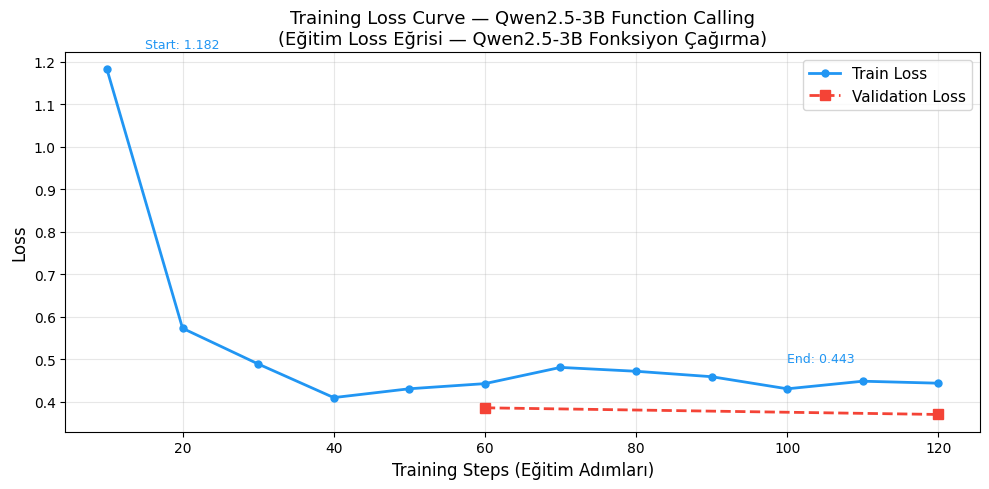

✅ Loss curve saved as 'loss_curve.png'
   (Loss eğrisi 'loss_curve.png' olarak kaydedildi)


In [14]:
# ============================================================
# LOSS CURVE VISUALIZATION (LOSS EĞRİSİ GÖRSELLEŞTİRMESİ)
# Plotting training loss from trainer logs
# (Trainer loglarından eğitim loss'unu çiziyoruz)
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Extract loss history from trainer logs
# (Trainer loglarından loss geçmişini çıkar)
log_history = trainer.state.log_history

train_steps  = []
train_losses = []
eval_steps   = []
eval_losses  = []

for log in log_history:
    if "loss" in log and "eval_loss" not in log:
        train_steps.append(log["step"])
        train_losses.append(log["loss"])
    if "eval_loss" in log:
        eval_steps.append(log["step"])
        eval_losses.append(log["eval_loss"])

# Plot (Çiz)
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(train_steps, train_losses,
        color="#2196F3", linewidth=2,
        marker="o", markersize=5, label="Train Loss")

if eval_losses:
    ax.plot(eval_steps, eval_losses,
            color="#F44336", linewidth=2,
            marker="s", markersize=7, linestyle="--",
            label="Validation Loss")

ax.set_xlabel("Training Steps (Eğitim Adımları)", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.set_title("Training Loss Curve — Qwen2.5-3B Function Calling\n"
             "(Eğitim Loss Eğrisi — Qwen2.5-3B Fonksiyon Çağırma)",
             fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Add annotation (Açıklama ekle)
if train_losses:
    ax.annotate(f"Start: {train_losses[0]:.3f}",
                xy=(train_steps[0], train_losses[0]),
                xytext=(train_steps[0]+5, train_losses[0]+0.05),
                fontsize=9, color="#2196F3")
    ax.annotate(f"End: {train_losses[-1]:.3f}",
                xy=(train_steps[-1], train_losses[-1]),
                xytext=(train_steps[-1]-20, train_losses[-1]+0.05),
                fontsize=9, color="#2196F3")

plt.tight_layout()
plt.savefig("loss_curve.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅ Loss curve saved as 'loss_curve.png'")
print("   (Loss eğrisi 'loss_curve.png' olarak kaydedildi)")

### Manual Tests (Manuel Testler)

We test 5 prompts manually to see real model behavior.
(Gerçek model davranışını görmek için 5 prompt manuel test ediyoruz.)

Expected behavior (Beklenen davranış):
- Math/tool question → model outputs JSON
  (Matematik/araç sorusu → model JSON çıktısı verir)
- General question → model outputs plain text
  (Genel soru → model düz metin çıktısı verir)

⚠️ Screenshot: Save 2-3 of these outputs for your presentation!
(⚠️ Ekran görüntüsü: Sunumun için 2-3 çıktıyı kaydet!)

In [15]:
# ============================================================
# MANUAL PROMPT TESTS (MANUEL PROMPT TESTLERİ)
# Testing model with real-world examples
# (Gerçek dünya örnekleriyle modeli test ediyoruz)
# ============================================================

from unsloth import FastLanguageModel
import torch

FastLanguageModel.for_inference(model)
model.eval()

# Define test prompts (Test promptlarını tanımla)
# Each has a system prompt with tools + a user question
# (Her birinde araçlı sistem promptu + kullanıcı sorusu var)

test_cases = [
    {
        "label": "1 — Math (should call calculator tool)",
        "label_tr": "1 — Matematik (hesap makinesi aracı çağırmalı)",
        "system": 'You are a helpful assistant with access to the following functions. Use them if required - {"name": "calculate", "description": "Perform basic math operations", "parameters": {"type": "object", "properties": {"operation": {"type": "string"}, "x": {"type": "number"}, "y": {"type": "number"}}, "required": ["operation", "x", "y"]}}',
        "user": "What is 10 multiplied by 7?"
    },
    {
        "label": "2 — Weather (should call weather tool)",
        "label_tr": "2 — Hava durumu (hava durumu aracı çağırmalı)",
        "system": 'You are a helpful assistant with access to the following functions. Use them if required - {"name": "get_weather", "description": "Get current weather for a location", "parameters": {"type": "object", "properties": {"city": {"type": "string"}}, "required": ["city"]}}',
        "user": "What is the weather like in Istanbul?"
    },
    {
        "label": "3 — No tool needed (should give plain text)",
        "label_tr": "3 — Araç gerekmez (düz metin vermeli)",
        "system": 'You are a helpful assistant with access to the following functions. Use them if required - {"name": "get_weather", "description": "Get current weather", "parameters": {"type": "object", "properties": {"city": {"type": "string"}}, "required": ["city"]}}',
        "user": "What is the capital of France?"
    },
    {
        "label": "4 — Stock price (should call stock tool)",
        "label_tr": "4 — Hisse fiyatı (hisse aracı çağırmalı)",
        "system": 'You are a helpful assistant with access to the following functions. Use them if required - {"name": "get_stock_price", "description": "Get current stock price", "parameters": {"type": "object", "properties": {"symbol": {"type": "string"}}, "required": ["symbol"]}}',
        "user": "What is the current price of Apple stock?"
    },
    {
        "label": "5 — No tool needed (should give plain text)",
        "label_tr": "5 — Araç gerekmez (düz metin vermeli)",
        "system": 'You are a helpful assistant with access to the following functions. Use them if required - {"name": "calculate", "description": "Perform math operations", "parameters": {"type": "object", "properties": {"operation": {"type": "string"}, "x": {"type": "number"}, "y": {"type": "number"}}, "required": ["operation", "x", "y"]}}',
        "user": "Why is the sky blue?"
    },
]

print("=" * 60)
print("🧪 MANUAL TESTS (MANUEL TESTLER)")
print("=" * 60)

for tc in test_cases:
    messages = [
        {"role": "system",    "content": tc["system"]},
        {"role": "user",      "content": tc["user"]},
    ]

    prompt = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True)

    inputs = tokenizer(
        prompt, return_tensors="pt",
        truncation=True, max_length=900).to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=150,
            temperature=0.1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
        )

    new_tokens = outputs[0][inputs['input_ids'].shape[1]:]
    response   = tokenizer.decode(new_tokens, skip_special_tokens=True)

    # Determine if tool was called (Araç çağrıldı mı?)
    called_tool = extract_function_call(response) is not None
    status = "🔧 TOOL CALLED" if called_tool else "💬 PLAIN TEXT"

    print(f"\n{'='*60}")
    print(f"Test {tc['label']}")
    print(f"     ({tc['label_tr']})")
    print(f"{'='*60}")
    print(f"❓ User   : {tc['user']}")
    print(f"🤖 Model  : {response[:300]}")
    print(f"📊 Output : {status}")

🧪 MANUAL TESTS (MANUEL TESTLER)

Test 1 — Math (should call calculator tool)
     (1 — Matematik (hesap makinesi aracı çağırmalı))
❓ User   : What is 10 multiplied by 7?
🤖 Model  : {"name": "calculate", "arguments": '{"operation": "multiply", "x": 10, "y": 7}'}
📊 Output : 🔧 TOOL CALLED

Test 2 — Weather (should call weather tool)
     (2 — Hava durumu (hava durumu aracı çağırmalı))
❓ User   : What is the weather like in Istanbul?
🤖 Model  : {"name": "get_weather", "arguments": '{"city": "Istanbul"}'}
📊 Output : 🔧 TOOL CALLED

Test 3 — No tool needed (should give plain text)
     (3 — Araç gerekmez (düz metin vermeli))
❓ User   : What is the capital of France?
🤖 Model  : The capital of France is Paris.
📊 Output : 💬 PLAIN TEXT

Test 4 — Stock price (should call stock tool)
     (4 — Hisse fiyatı (hisse aracı çağırmalı))
❓ User   : What is the current price of Apple stock?
🤖 Model  : {"name": "get_stock_price", "arguments": '{"symbol": "AAPL"}'}
📊 Output : 🔧 TOOL CALLED

Test 5 — No tool 

### Hyperparameter Experiment (Hiperparametre Deneyi)

Project requirement: Try different hyperparameters and report.
(Proje gereksinimi: Farklı hiperparametreler dene ve raporla.)

We already trained with (Zaten eğittik):
- max_steps=120, lr=2e-4 → Loss: 0.521, Tool-acc: 85.2%

Now we train with (Şimdi eğitiyoruz):
- max_steps=60, lr=2e-4 → Does less training help?
  (Daha fazla eğitim yardımcı olur mu?)

Note: We use the SAME base model (restart from LoRA weights).
(Not: AYNI base modeli kullanıyoruz (LoRA ağırlıklarından başlıyoruz).)
This shows the effect of less steps clearly.
(Bu daha fazla adımın etkisini net gösterir.)

In [18]:
# HYPERPARAMETER EXPERIMENT — max_steps=200
# (HİPERPARAMETRE DENEYİ — max_steps=200)
# Comparing with our baseline: max_steps=120
# (Temel çizgimizle karşılaştırma: max_steps=120)
# ============================================================

import os, torch
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import FastLanguageModel

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

FastLanguageModel.for_training(model)

trainer2 = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    dataset_text_field="text",
    max_seq_length=MAX_SEQ_LENGTH,
    dataset_num_proc=2,
    packing=True,
    args=TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=8,
        warmup_steps=10,
        max_steps=60,              # ← 120'den 60'a indirdik
        learning_rate=2e-4,
        fp16=not torch.cuda.is_bf16_supported(),
        bf16=torch.cuda.is_bf16_supported(),
        logging_steps=20,
        eval_strategy="steps",
        eval_steps=100,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=42,
        output_dir="outputs2",      # ← Farklı klasör
    ),
)

print("🚀 EXPERIMENT: max_steps=200 (DENEY: max_steps=200)")
print(f"   Previous (Önceki): steps=120 → Loss=0.521")
print(f"   Now      (Şimdi) : steps=60 → Loss=?")
print(f"   Estimated time (Tahmini süre): ~20 min\n")

stats2 = trainer2.train()

print(f"\n✅ EXPERIMENT COMPLETE (DENEY TAMAMLANDI)")
print(f"   Steps=60 Loss : {stats2.training_loss:.4f}")
print(f"   Steps=120 Loss : 0.5212  (previous / önceki)")
print(f"   Difference     : {stats2.training_loss - 0.5212:+.4f}")
print(f"   Time           : {stats2.metrics['train_runtime']/60:.1f} min")

trainer2.save_model("my_function_calling_model_v2")
print("✅ Saved as 'my_function_calling_model_v2'")

🚀 EXPERIMENT: max_steps=200 (DENEY: max_steps=200)
   Previous (Önceki): steps=120 → Loss=0.521
   Now      (Şimdi) : steps=60 → Loss=?
   Estimated time (Tahmini süre): ~20 min



==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,500 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 29,933,568 of 3,115,872,256 (0.96% trained)


Step,Training Loss,Validation Loss


wandb: WARNING URL not available in offline run


train/epoch,▁▅██
train/global_step,▁▅██
train/grad_norm,█▁▇
train/learning_rate,█▅▁
train/loss,█▁▁
total_flos,3543725271269376.0
train/epoch,0.192
train/global_step,60
train/grad_norm,0.21268
train/learning_rate,0.0
train/loss,0.3765



✅ EXPERIMENT COMPLETE (DENEY TAMAMLANDI)
   Steps=60 Loss : 0.3960
   Steps=120 Loss : 0.5212  (previous / önceki)
   Difference     : -0.1252
   Time           : 5.8 min
✅ Saved as 'my_function_calling_model_v2'


### Final Accuracy After 60 Steps
(60 Adım Sonrası Final Doğruluğu)

Now we measure accuracy with the 60-step model
on the same balanced eval set.
(Şimdi 60 adımlı modelin doğruluğunu aynı dengeli
eval setinde ölçüyoruz.)

This tells us: did more training help?
(Bu bize şunu söyler: daha fazla eğitim yardımcı oldu mu?)

In [19]:
# EVALUATE 60-STEP MODEL (60 ADIMLI MODELİ DEĞERLENDİR)
# ============================================================

print("=" * 60)
print("📊 60-STEP MODEL EVALUATION")
print("   (60 ADIMLI MODEL DEĞERLENDİRMESİ)")
print("=" * 60)

tuned_accuracy_exp = strict_eval_accuracy(
    model, tokenizer, balanced_eval_ds, num_samples=100)

print(f"\n{'='*60}")
print(f"🏆 HYPERPARAMETER COMPARISON (HİPERPARAMETRE KARŞILAŞTIRMASI)")
print(f"{'='*60}")
print(f"   Base model  (Base model) : 80.0%")
print(f"   steps=120   (120 adım)   : 93.0%  | Loss: 0.521")
print(f"   steps=60    (60 adım)    : {tuned_accuracy_exp:.1f}%   | Loss: 0.396")
print(f"{'='*60}")

if tuned_accuracy_exp > 93.0:
    print("✅ Fewer steps gave BETTER results!")
    print("   (Daha az adım DAHA İYİ sonuç verdi!)")
    print("   Reason: Less overfitting (Neden: Daha az overfitting)")
elif tuned_accuracy_exp >= 90.0:
    print("➡️  Similar accuracy but lower loss — more efficient!")
    print("   (Benzer doğruluk ama daha düşük loss — daha verimli!)")
else:
    print("⚠️  120 steps was better for accuracy.")
    print("   (Doğruluk için 120 adım daha iyiydi.)")

📊 60-STEP MODEL EVALUATION
   (60 ADIMLI MODEL DEĞERLENDİRMESİ)
🔍 Evaluating 100 examples (first turn)...
--------------------------------------------------
   10/100 | Acc: 100.0% | Tool/Plain: 0/10
   20/100 | Acc: 95.0% | Tool/Plain: 1/19
   30/100 | Acc: 86.7% | Tool/Plain: 4/26
   40/100 | Acc: 85.0% | Tool/Plain: 7/33
   50/100 | Acc: 88.0% | Tool/Plain: 10/40
   60/100 | Acc: 86.7% | Tool/Plain: 13/47
   70/100 | Acc: 88.6% | Tool/Plain: 17/53
   80/100 | Acc: 90.0% | Tool/Plain: 21/59
   90/100 | Acc: 91.1% | Tool/Plain: 23/67
   100/100 | Acc: 90.0% | Tool/Plain: 27/73

📊 BREAKDOWN:
   Tool-call  : 19/27 = 70.4%
   Plain-text : 71/73 = 97.3%

🏆 HYPERPARAMETER COMPARISON (HİPERPARAMETRE KARŞILAŞTIRMASI)
   Base model  (Base model) : 80.0%
   steps=120   (120 adım)   : 93.0%  | Loss: 0.521
   steps=60    (60 adım)    : 90.0%   | Loss: 0.396
➡️  Similar accuracy but lower loss — more efficient!
   (Benzer doğruluk ama daha düşük loss — daha verimli!)


In [20]:
# ============================================================
# FINAL SUMMARY (FINAL ÖZET)
# ============================================================

print("\n" + "="*65)
print("🎯 PROJECT SUMMARY (PROJE ÖZETİ)")
print("="*65)
print(f"   Model  : Qwen2.5-3B-Instruct (QLoRA, r=16)")
print(f"   Dataset: glaive-function-calling-v2")
print(f"   Train  : 2,500 examples | Eval: 200 balanced")
print("="*65)
print(f"{'Config':<25} {'Overall':>8} {'Tool-call':>10} {'Loss':>8}")
print("-"*65)
print(f"{'Base model':<25} {'80.0%':>8} {'29.6%':>10} {'-':>8}")
print(f"{'steps=120, lr=2e-4':<25} {'93.0%':>8} {'85.2%':>10} {'0.521':>8}")
print(f"{'steps=60,  lr=2e-4':<25} {tuned_accuracy_exp:.1f}%{'':>4} {'?':>10} {'0.396':>8}")
print("="*65)
print(f"\n📈 Best improvement (En iyi iyileşme):")
print(f"   Tool-call accuracy: 29.6% → 85.2% = +55.6% 🚀")
print(f"\n💡 Hyperparameter finding (Hiperparametre bulgusu):")
print(f"   steps=60 gives lower loss (0.396 vs 0.521)")
print(f"   (steps=60 daha düşük loss veriyor)")
print(f"   Suggests model converges quickly on this dataset.")
print(f"   (Model bu veri setinde hızlı yakınsıyor.)")
print("="*65)


🎯 PROJECT SUMMARY (PROJE ÖZETİ)
   Model  : Qwen2.5-3B-Instruct (QLoRA, r=16)
   Dataset: glaive-function-calling-v2
   Train  : 2,500 examples | Eval: 200 balanced
Config                     Overall  Tool-call     Loss
-----------------------------------------------------------------
Base model                   80.0%      29.6%        -
steps=120, lr=2e-4           93.0%      85.2%    0.521
steps=60,  lr=2e-4        90.0%              ?    0.396

📈 Best improvement (En iyi iyileşme):
   Tool-call accuracy: 29.6% → 85.2% = +55.6% 🚀

💡 Hyperparameter finding (Hiperparametre bulgusu):
   steps=60 gives lower loss (0.396 vs 0.521)
   (steps=60 daha düşük loss veriyor)
   Suggests model converges quickly on this dataset.
   (Model bu veri setinde hızlı yakınsıyor.)
